# import required libraries

In [1]:
import math
import multiprocessing
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import (BatchNormalization, Conv2D, Dense, Dropout, Flatten,
                          Input, LeakyReLU, MaxPooling2D, concatenate)
from keras.models import Model
from keras.utils import Sequence, plot_model
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Software Configurations

In [2]:
# the directory containing the dataset. should NOT contain a trailing slash.
DATA_DIR = './../data'
DIST_DIR = './../dist'

In [3]:
# features
ALPHABET = 'ACDEFGHIKLMNPQRSTVWY'
PEPTIDE_MAX_LEN = 14
MHC_MAX_LEN = 372

# model
TRAIN_DATA_RATIO = 0.70
BATCH_SIZE = 64
EPOCHS = 10

In [4]:
# random seed for reproducibility
RANDOM_SEED = 8410304

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Hardware

In [5]:
# hardware
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) == 0:
    print("No GPU detected.")
else:
    print("GPU detected:", gpus[0])
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

No GPU detected.


2023-08-05 23:10:49.887228: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-05 23:10:49.915566: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
NUM_CPU_THREADS = multiprocessing.cpu_count()

print('CPU threads used in data generator:', NUM_CPU_THREADS)

CPU threads used in data generator: 16


# Load Dataset

In [7]:
df = pd.read_csv(f'{DATA_DIR}/binding_affinity_data.csv', index_col=0)
df

,MHC_sequence,MHC_type,peptide_sequence,label
0,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...,HLA-B*27:05,ERLKEVQKR,1
1,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...,HLA-B*27:05,KPRKTAEVAGKTL,1
2,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...,HLA-B*27:05,KEARRIIKK,1
3,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...,HLA-B*27:05,EEKITEAKEL,0
4,MRVTAPRTLLLLLWGAVALTETWAGSHSMRYFHTSVSRPGRGEPRF...,HLA-B*27:05,SLPSSRAARVPG,0
...,...,...,...,...
1793060,MAVMAPRTLLLLLLGALALTQTWAGSHSMRYFFTSVSRPGRGEPRF...,HLA-A*32:15,TLSKSTAII,0
1793061,MRVTAPRTVLLLLSGALALTETWAGSHSMRYFYTAMSRPGRGEPRF...,HLA-B*15:09,KAFLPAMTK,0
1793062,MRVTAPRTVLLLLSGALALTETWAGSHSMRYFYTAMSRPGRGEPRF...,HLA-B*15:09,VRIPRNSPL,0
1793063,MAVMAPRTLVLLLSGALALTQTWAGSHSMRYFYTSVSRPGRGEPRF...,HLA-A*66:01,GEHANDYAE,0


# Label Distribution

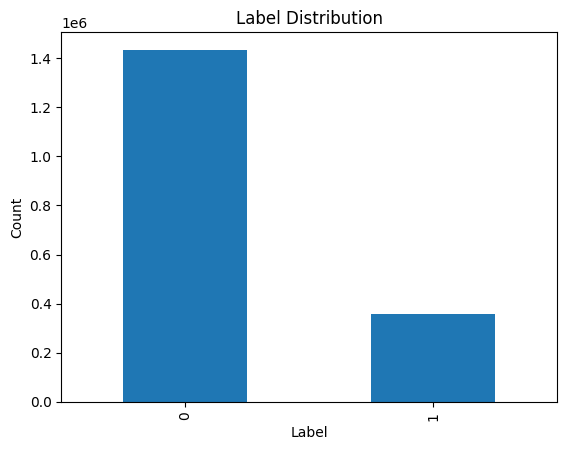

In [8]:
label_dist = df.groupby('label').count().iloc[:, 0]
label_dist.plot.bar(title='Label Distribution', xlabel='Label', ylabel='Count')
plt.show()

# Basic Features Extraction

In [9]:
def one_hot_encode_sequence(sequence, max_length):

    matrix = np.zeros(shape=(1, max_length, 1 + len(ALPHABET)), dtype='int32')
    for i in range(max_length):
        if i < len(sequence) and sequence[i] in ALPHABET:
            aa_index = ALPHABET.index(sequence[i])
            matrix[0][i][aa_index] = 1
        else:
            matrix[0][i][-1] = 1
    return matrix

In [10]:
# We use a data generator to reduce memory usage
class DataGenerator(Sequence):
    def __init__(self, df):
        self.df = df
        self.num_samples = len(df)
        self.indices = np.arange(self.num_samples)
        self.steps_per_epoch = math.ceil(self.num_samples / BATCH_SIZE)

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, index):
        batch_indices = self.indices[index * BATCH_SIZE: (index + 1) * BATCH_SIZE]
        batch_data = self.df.iloc[batch_indices]

        x_mhcs_batch = np.stack(batch_data['MHC_sequence'].apply(
            lambda seq: one_hot_encode_sequence(seq, max_length=MHC_MAX_LEN))  # type: ignore
        )
        x_peptides_batch = np.stack(batch_data['peptide_sequence'].apply(
            lambda seq: one_hot_encode_sequence(seq, max_length=PEPTIDE_MAX_LEN))  # type: ignore
        )
        y_batch = batch_data['label'].to_numpy()

        return [x_mhcs_batch, x_peptides_batch], y_batch

In [11]:
labels = df['label'].to_numpy()
labels.shape

(1793065,)

# Computing Class Weights to Mitigate Class Imbalance

In [12]:
# Compute class weights
class_labels = np.unique(labels)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Convert class weights to a dictionary
class_weight_dict = dict(zip(class_labels, class_weights))

class_weight_dict

{0: 0.6252410385947685, 1: 2.4961508049202874}

# Split Dataset

In [13]:
# Split data into training, validation, and test sets

mhcs_train, mhcs_temp, peptides_train, peptides_temp, labels_train, labels_temp = train_test_split(
    df['MHC_sequence'], df['peptide_sequence'], df['label'], 
    test_size=1 - TRAIN_DATA_RATIO, 
    random_state=RANDOM_SEED
)

mhcs_val, mhcs_test, peptides_val, peptides_test, labels_val, labels_test = train_test_split(
    mhcs_temp, peptides_temp, labels_temp, 
    test_size=0.50, 
    random_state=RANDOM_SEED,
)

# Create data generators
train_generator = DataGenerator(df.iloc[mhcs_train.index])
val_generator = DataGenerator(df.iloc[mhcs_val.index])
test_generator = DataGenerator(df.iloc[mhcs_test.index])

# Model

In [14]:
# Create the MHC sequence branch
mhc_input = Input(shape=(1, MHC_MAX_LEN, 1 + len(ALPHABET)))
mhc_conv1 = Conv2D(filters=32, kernel_size=(1, 3), activation='relu')(mhc_input)
mhc_batch1 = BatchNormalization()(mhc_conv1)
mhc_leaky1 = LeakyReLU()(mhc_batch1)
mhc_conv2 = Conv2D(filters=32, kernel_size=(1, 3), activation='relu')(mhc_leaky1)
mhc_batch2 = BatchNormalization()(mhc_conv2)
mhc_leaky2 = LeakyReLU()(mhc_batch2)
mhc_pool = MaxPooling2D(pool_size=(1, 10))(mhc_leaky2)
mhc_drop = Dropout(0.5)(mhc_pool)
mhc_conv3 = Conv2D(filters=32, kernel_size=(1, 3), activation='relu')(mhc_drop)
mhc_batch3 = BatchNormalization()(mhc_conv3)
mhc_leaky3 = LeakyReLU()(mhc_batch3)
mhc_flatten = Flatten()(mhc_leaky3)


# Create the peptide sequence branch
peptide_input = Input(shape=(1, PEPTIDE_MAX_LEN, 1 + len(ALPHABET)))
peptide_conv = Conv2D(filters=32, kernel_size=(1, 3), activation='relu')(peptide_input)
peptide_batch = BatchNormalization()(peptide_conv)
peptide_pool = MaxPooling2D(pool_size=(1, 3))(peptide_batch)
peptide_flatten = Flatten()(peptide_pool)


# Merge the two branches
merged = concatenate([mhc_flatten, peptide_flatten])

# Add some fully connected layers for classification
dense_layer = Dense(64, activation='relu')(merged)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

# Create the model
model = Model(inputs=[mhc_input, peptide_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 372, 21)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1, 370, 32)           2048      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1, 370, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 1, 370, 32)           0         ['batch_normalization[0][0

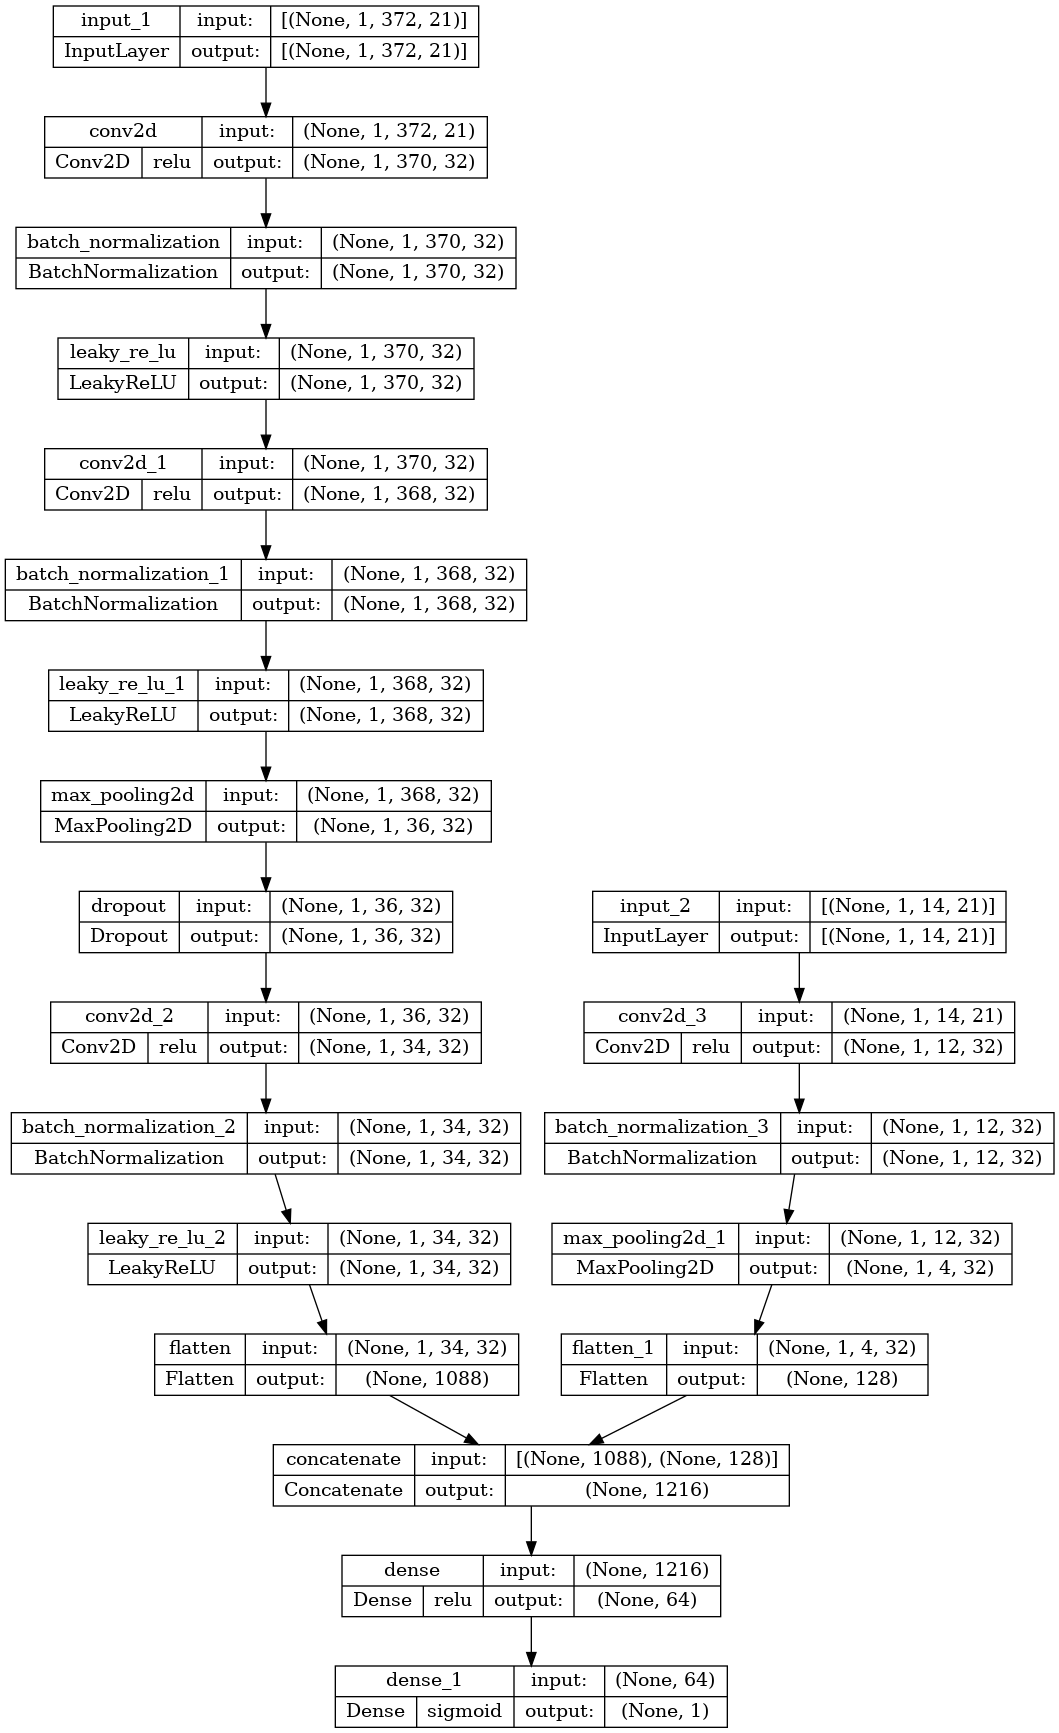

In [16]:
# print the model
# NOTE: requires pydot (pip install pydot) and graphviz (https://graphviz.gitlab.io/download/)

plot_model(
    model, 
    show_shapes=True, 
    show_layer_names=True,
    show_layer_activations=True,
)

# Callbacks

In [17]:
callbacks = [
    ModelCheckpoint(filepath= DIST_DIR + '/model_at_epoch_{epoch}.keras'),
    EarlyStopping(monitor= 'val_loss' , patience= 5),
]

# Train

In [18]:
history = model.fit(
    train_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    epochs=EPOCHS, 
    validation_data=val_generator,
    use_multiprocessing=True,
    workers=NUM_CPU_THREADS,
)


Epoch 1/10
19612/19612 [==============================] - 164s 8ms/step - loss: 0.2923 - accuracy: 0.8693 - val_loss: 0.2836 - val_accuracy: 0.8824
Epoch 2/10
19612/19612 [==============================] - 159s 8ms/step - loss: 0.2321 - accuracy: 0.9049 - val_loss: 0.2270 - val_accuracy: 0.9094
Epoch 3/10
19612/19612 [==============================] - 161s 8ms/step - loss: 0.2196 - accuracy: 0.9110 - val_loss: 0.2568 - val_accuracy: 0.8957
Epoch 4/10
19612/19612 [==============================] - 156s 8ms/step - loss: 0.2131 - accuracy: 0.9142 - val_loss: 0.2090 - val_accuracy: 0.9169
Epoch 5/10
19612/19612 [==============================] - 159s 8ms/step - loss: 0.2093 - accuracy: 0.9158 - val_loss: 0.2379 - val_accuracy: 0.9048
Epoch 6/10
19612/19612 [==============================] - 161s 8ms/step - loss: 0.2064 - accuracy: 0.9171 - val_loss: 0.2402 - val_accuracy: 0.9040
Epoch 7/10
19612/19612 [==============================] - 153s 8ms/step - loss: 0.2041 - accuracy: 0.9182 - val_

# Plotting Training Loss vs. Epoch

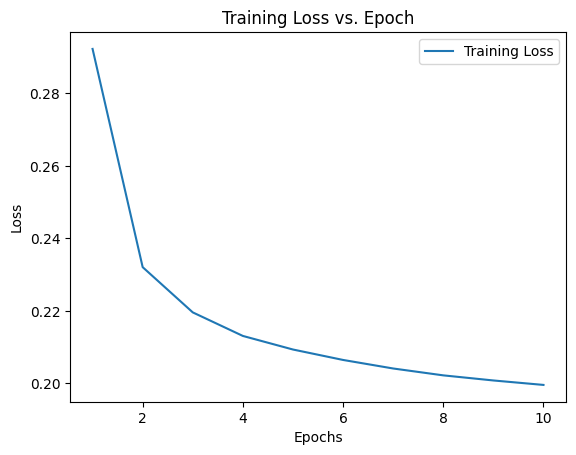

In [19]:
# Access the training loss values from the history object
train_loss = history.history['loss']

# Create an array for the epochs
epochs = 1 + np.array(history.epoch)

# Plot the training loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Test

In [20]:
labels_pred_prob = model.predict(
    test_generator,
    use_multiprocessing=True,
    workers=NUM_CPU_THREADS,
)
labels_pred = (labels_pred_prob >= 0.5).astype(int)

4203/4203 [==============================] - 15s 4ms/step


In [21]:
# compute accuracy, precision, recall, and F1-score
accuracy = accuracy_score(labels_test, labels_pred)
precision = precision_score(labels_test, labels_pred)
recall = recall_score(labels_test, labels_pred)
f1 = f1_score(labels_test, labels_pred)

# compute AUC
fpr, tpr, thresholds = roc_curve(labels_test, labels_pred_prob)
roc_auc = roc_auc_score(labels_test, labels_pred_prob)

# compute the confusion matrix
cm = confusion_matrix(labels_test, labels_pred)

print('Test phase metrics:')
print(f'{"Accuracy:":20s} {100 * accuracy:.3f}%')
print(f'{"Precision:":20s} {100 * precision:.3f}%')
print(f'{"Recall:":20s} {100 * recall:.3f}%')
print(f'{"F1-score:":20s} {100 * f1:.3f}%')
print(f'{"AUC:":20s} {roc_auc:.3f}')
print(f'{"Confusion matrix:"}\n{cm}')


Test phase metrics:
Accuracy:            91.216%
Precision:           71.499%
Recall:              93.243%
F1-score:            80.936%
AUC:                 0.975
Confusion matrix:
[[195184  19991]
 [  3634  50151]]


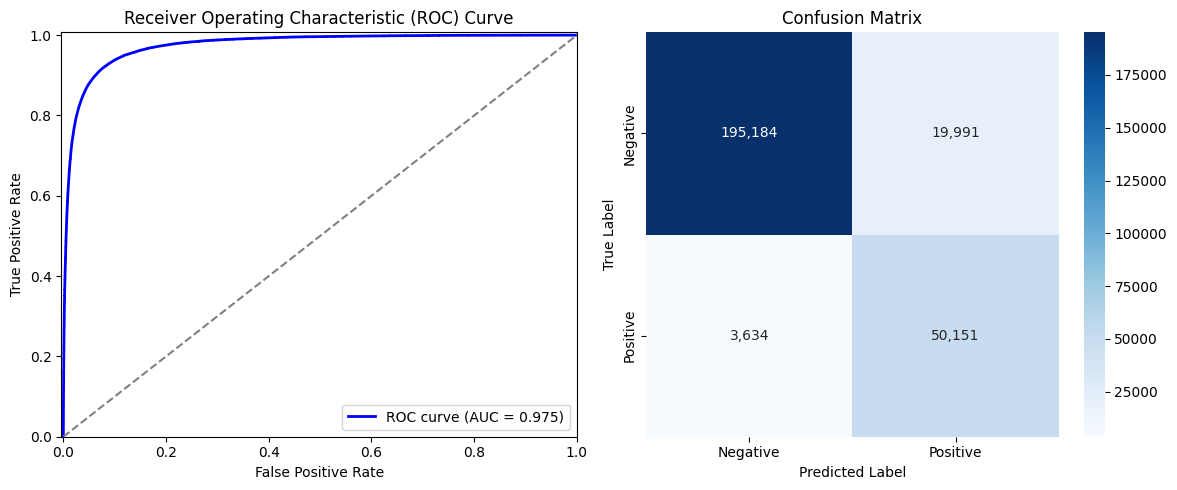

In [22]:
plt.figure(figsize=(12, 5))

# Plot the ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([-0.004, 1.00])
plt.ylim([0.0, 1.007])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Plot confusion matrix
plt.subplot(1, 2, 2)

sns.heatmap(
    data=cm, 
    annot=True, 
    fmt=',',
    cmap='Blues', 
    xticklabels=['Negative', 'Positive'], # type: ignore
    yticklabels=['Negative', 'Positive'], # type: ignore
)
plt.xlabel('Predicted Label')
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# display plots
plt.tight_layout()
plt.show()


In [23]:
pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC\'s AUC'],
    'Value': [f'{100 * accuracy:.3f}%', f'{100 * precision:.3f}%', f'{100 * recall:.3f}%', f'{100 * f1:.3f}%', f'{roc_auc:.3f}']
})

,Metric,Value
0,Accuracy,91.216%
1,Precision,71.499%
2,Recall,93.243%
3,F1-score,80.936%
4,ROC's AUC,0.975
